In [1]:
!pip install scikit-learn==1.5.2 
!pip install autogluon.tabular
!pip install ray==2.10.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 88.7 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.3/487.3 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.0/71.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278

# Thư viện

In [2]:
import os
import gc
import pickle
import shutil
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression, Ridge

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier, early_stopping
from xgboost import XGBClassifier

from autogluon.tabular import TabularPredictor

import optuna

import warnings
warnings.filterwarnings('ignore')

In [3]:
class CFG:
    train_path = '/kaggle/input/playground-series-s4e11/train.csv'
    test_path = '/kaggle/input/playground-series-s4e11/test.csv'
    sample_sub_path = '/kaggle/input/playground-series-s4e11/sample_submission.csv'
    
    original_data_path = '/kaggle/input/depression-surveydataset-for-analysis/final_depression_dataset_1.csv'
    
    target = 'Depression'
    n_folds = 5
    seed = 42

# Chuẩn bị dữ liệu

### Hàm áp dụng tiền xử lý dữ liệu tương tự trong file EDA.


In [ ]:
def process_detailed_impute(df_train, df_test, df_original, model_name='lgbm'):
    train = df_train.copy()
    test = df_test.copy()
    original = df_original.copy()
    all_dfs = [train, test, original] 

    #  Định nghĩa các ánh xạ (maps) 
    gender_map = {'Male': 1, 'Female': 0}
    work_map = {'Working Professional': 1, 'Student': 0}
    suicidal_map = {'Yes': 1, 'No': 0}
    family_map = {'Yes': 1, 'No': 0}
    sleep_map = {
        'Less than 5 hours': 4, '7-8 hours': 7.5, 'More than 8 hours': 9,
        '5-6 hours': 5.5, '3-4 hours': 3.5,
    }
    diet_map = {'Healthy': 2, 'Moderate': 1, 'Unhealthy': 0}

    for df in all_dfs:
        try:
            #  Áp dụng Ánh xạ 
            df['Gender'] = df['Gender'].map(gender_map)
            df['Working Professional or Student'] = df['Working Professional or Student'].map(work_map) 
            df['Have you ever had suicidal thoughts ?'] = df['Have you ever had suicidal thoughts ?'].map(suicidal_map) 
            df['Family History of Mental Illness'] = df['Family History of Mental Illness'].map(family_map) 
            df['Sleep Duration'] = df['Sleep Duration'].map(sleep_map)
            df['Dietary Habits'] = df['Dietary Habits'].map(diet_map) 

            #  Xử lý Imputation có điều kiện 
            for col in ['Work Pressure', 'Job Satisfaction']:
                df[col] = df.apply(
                    lambda row: 0 if row['Working Professional or Student'] == 0 and pd.isnull(row[col]) else row[col],
                    axis=1
                )
            for col in ['Academic Pressure', 'Study Satisfaction']:
                df[col] = df.apply(
                    lambda row: 0 if row['Working Professional or Student'] == 1 and pd.isnull(row[col]) else row[col],
                    axis=1
                )
        except KeyError as e:
            print(f"Cảnh báo: Không tìm thấy cột {e} trong process_detailed_impute. Bỏ qua...")
            pass

    
    #  Xử lý Imputation còn lại 
    numeric_cols = ['Age', 'CGPA', 'Work/Study Hours']
    categorical_cols = ['Academic Pressure', 'Work Pressure', 'Study Satisfaction', 
                    'Job Satisfaction', 'Financial Stress', 'Sleep Duration', 'Dietary Habits',
                    'Name', 'City', 'Profession', 'Degree']
    for col in numeric_cols:
        if col in train.columns:
            med = train[col].median()
            for df in all_dfs:
                df[col] = df[col].fillna(med)

    for col in categorical_cols:
        if col in train.columns:
            mode_val = train[col].mode()[0]
            for df in all_dfs:
                df[col] = df[col].fillna(mode_val)
    
    if model_name == 'cb':
        cat_cols = train.columns.tolist() 
    else:
        cat_cols = train.select_dtypes(include='object').columns
    
    for df in [train, test, original]:
        for col in cat_cols:
            if col in df.columns:
                df[col] = df[col].astype(str).astype('category')

    if model_name != 'cb':
        for col in cat_cols:
            if all(col in df.columns for df in [train, test, original]):
                try:
                    common_cats = train[col].cat.categories.union(original[col].cat.categories)
                    train[col] = train[col].cat.set_categories(common_cats)
                    original[col] = original[col].cat.set_categories(common_cats)
                    test[col] = test[col].cat.set_categories(common_cats)
                except Exception:
                    pass

            
    return train, test, original

### Hàm xử lý dữ liệu không qua tiền xử lý:  
- CatBoost xử lý được mọi loại biến categorical một cách tự động, kể cả khi biến đó là số nhưng mang ý nghĩa phân loại.Vì vậy, đối với CatBoost thì xem tất cả các cột là categorical.
- Ngược lại, các mô hình khác (LightGBM, XGBoost, LR…) chỉ hiểu categorical khi cột có dtype object. Nếu ép toàn bộ cột thành categorical sẽ làm mô hình học sai hoặc gây lỗi. Do đó, chỉ chọn các cột có dtype object để đưa về categorical.
- Với mỗi cột categorical xuất hiện trong cả 3 DataFrame:
    - Lấy hợp các category giữa train và original.
    - Áp danh sách category chung đó vào train, test và original.
    
    Điều này tránh lỗi mismatch category khi huấn luyện.

In [5]:
def process_native(df_train, df_test, df_original, model_name='lgbm'):
    train_df = df_train.copy()
    test_df = df_test.copy()
    original_df = df_original.copy()
 
    if model_name == 'cb':
        cat_cols = train_df.columns.tolist() 
    else:
        cat_cols = train_df.select_dtypes(include='object').columns
    
    for df in [train_df, test_df, original_df]:
        for col in cat_cols:
            if col in df.columns:
                df[col] = df[col].astype(str).astype('category')
            
    # Đồng bộ categories
    for col in cat_cols:
        if col in original_df.columns and col in train_df.columns and col in test_df.columns:
            try:
                common_cats = train_df[col].cat.categories.union(original_df[col].cat.categories)
                train_df[col] = train_df[col].cat.set_categories(common_cats)
                original_df[col] = original_df[col].cat.set_categories(common_cats)
                test_df[col] = test_df[col].cat.set_categories(common_cats)
            except Exception:
                pass 
            
    return train_df, test_df, original_df

### Hàm load dữ liệu theo pipeline
- Đọc train, test và original; xoá cột id; map target từ Yes/No: 1/0.
- Lấy y_train, y_original và tách phần features của từng bộ dữ liệu.
- p1, p3: dùng process_native (chỉ chuẩn hoá dtype).
- p2, p4: dùng process_detailed_impute (mapping + impute).
- p1/p2: dữ liệu chỉ gồm train + original.
- p3/p4: dữ liệu gồm train + original + pseudo.

In [6]:
def get_data(pipeline_type='p1', pseudo_data=None, model_name='lgbm'):
    #  Load dữ liệu 
    df_train = pd.read_csv(CFG.train_path)
    df_test = pd.read_csv(CFG.test_path)
    df_original = pd.read_csv(CFG.original_data_path)
    
    for df in [df_train, df_test]:
        if 'id' in df.columns: df.drop('id', axis=1, inplace=True)
    
    # Map target nếu là object
    for df in [df_original]:
        if df[CFG.target].dtype == 'object':
            df[CFG.target] = df[CFG.target].map({'Yes':1, 'No':0})
    
    y_train = df_train[CFG.target]
    X_train = df_train.drop(CFG.target, axis=1)
    y_original = df_original[CFG.target]
    X_original = df_original.drop(CFG.target, axis=1)
    X_test = df_test.copy()
    
    #  Xử lý dữ liệu 
    if pipeline_type in ['p1', 'p3']:
        X_train_proc, X_test_proc, X_orig_proc = process_native(X_train, X_test, X_original, model_name=model_name)
    elif pipeline_type in ['p2', 'p4']:
        X_train_proc, X_test_proc, X_orig_proc = process_detailed_impute(X_train, X_test, X_original, model_name=model_name)
    else:
        raise ValueError("pipeline_type không hợp lệ")
    
    #  Kết hợp dữ liệu 
    common_cols = [c for c in X_train_proc.columns if c in X_orig_proc.columns]

    if pipeline_type in ['p1', 'p2']:
        X_final = pd.concat([X_train_proc[common_cols], X_orig_proc[common_cols]], ignore_index=True)
        y_final = pd.concat([y_train, y_original], ignore_index=True)
    elif pipeline_type in ['p3', 'p4']:
        if pseudo_data is None:
            raise ValueError("Cần pseudo_data cho pipeline p3 hoặc p4")
        X_pseudo, y_pseudo = pseudo_data
        X_final = pd.concat([X_train_proc[common_cols], X_orig_proc[common_cols], X_pseudo[common_cols]], ignore_index=True)
        y_final = pd.concat([y_train, y_original, y_pseudo], ignore_index=True)
    
    #  Xử lý X_test 
    if pipeline_type in ['p1', 'p3']:
        X_test_final = X_test_proc
    else:  # p2, p4
        X_test_final = X_test_proc[common_cols]
    
    return X_final, y_final, X_test_final


# Huấn luyện model

### Hàm huấn luyện các base models:  XGBoost Classifier, LightGBM, CatBoost Classifier, Logistic Regression
- Khởi tạo mảng kết quả
    - oof_pred_probs: lưu dự đoán OOF (mỗi mẫu train có đúng 1 dự đoán).
    - test_pred_probs: trung bình dự đoán test qua các fold.
- Chia dữ liệu theo tỷ lệ lớp ổn định giữa các fold.
- Huấn luyện theo từng fold
    - Tách X_train, X_val cho fold hiện tại.
    - Clone mô hình để đảm bảo mô hình mới hoàn toàn.
    - Huấn luyện theo đúng loại model
- Ghi OOF vào đúng vị trí val_idx.
- Dự đoán test và cộng dồn để sau chia trung bình.
- Tính accuracy cho từng fold.


In [7]:
class Trainer:
    def __init__(self, model, config=CFG):
        self.model = model
        self.config = config

    def fit_predict(self, X, y, X_test, threshold=0.5):
        #  Convert X, y, X_test thành DataFrame/Series ngoài loop 
        if not isinstance(X, pd.DataFrame): X = pd.DataFrame(X)
        if not isinstance(y, pd.Series): y = pd.Series(y)
        if not isinstance(X_test, pd.DataFrame): X_test = pd.DataFrame(X_test)

        print(f'Training {self.model.__class__.__name__}\n')

        scores = []    
        oof_pred_probs = np.zeros(X.shape[0])
        test_pred_probs = np.zeros(X_test.shape[0])
        
        skf = StratifiedKFold(
            n_splits=self.config.n_folds, 
            random_state=self.config.seed, 
            shuffle=True
        )
        
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            #  Tạo bản copy cho fold hiện tại 
            X_train, X_val = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            X_test_fold = X_test.copy() 

            model = clone(self.model)

            #  CatBoost 
            if isinstance(model, CatBoostClassifier):
                cat_features = X_train.columns.tolist()
                model.fit(
                    X_train, y_train,
                    eval_set=[(X_val, y_val)],
                    cat_features=cat_features,
                    early_stopping_rounds=100,
                    verbose=0
                )

            #  LGBM 
            elif isinstance(model, LGBMClassifier):
                cat_features = X_train.select_dtypes(include='category').columns.tolist()
                model.fit(
                    X_train, y_train,
                    eval_set=[(X_val, y_val)],
                    eval_metric='logloss', 
                    categorical_feature=cat_features,
                    callbacks=[early_stopping(100, verbose=False)]
                )

            #  XGB 
            elif isinstance(model, XGBClassifier):
                # Chuyển các cột category sang int riêng cho fold
                cat_cols = X_train.select_dtypes(include='category').columns
                for col in cat_cols:
                    X_train[col] = X_train[col].cat.codes
                    X_val[col] = X_val[col].cat.codes
                    X_test_fold[col] = X_test_fold[col].cat.codes
                
                model.fit(
                    X_train, y_train,
                    eval_set=[(X_val, y_val)],
                    eval_metric='logloss',
                    early_stopping_rounds=100,
                    verbose=False
                )

            else:
                model.fit(X_train, y_train)
            
            #  Dự đoán OOF và Test 
            y_pred_probs = model.predict_proba(X_val)[:, 1]
            oof_pred_probs[val_idx] = y_pred_probs  

            test_pred_probs += model.predict_proba(X_test_fold)[:, 1] / self.config.n_folds
            
            score = accuracy_score(y_val, (y_pred_probs > threshold).astype(int))
            scores.append(score)
            print(f' Fold {fold_idx + 1} - Accuracy: {score:.6f}')
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs, X_test_fold
            gc.collect()
            
        #  Overall Score 
        overall_score = accuracy_score(y, (oof_pred_probs > threshold).astype(int))
        print(f'\nOverall: {overall_score:.6f} | Average: {np.mean(scores):.6f} ± {np.std(scores):.6f}')
    
        return oof_pred_probs, test_pred_probs, scores

### Hàm huấn luyện base model bằng AutoGluon
- Tạo dữ liệu train: Ghép X và y thành một bảng duy nhất để AutoGluon huấn luyện.
- Khởi tạo AutoGluon TabularPredictor
    - Chỉ định biến mục tiêu
    - Chọn metric là accuracy
    - Đặt đường dẫn lưu mô hình
- Huấn luyện mô hình AutoML  
    Dùng fit() với:
    - presets='high_quality'
    - num_bag_folds = số fold CV
    - fit_weighted_ensemble=True
    - time_limit_sec để giới hạn thời gian chạy
- Lấy dự đoán OOF: predict_proba_oof(): lấy xác suất dự đoán cho lớp 1 cho toàn bộ train, đúng thứ tự index.
- Lấy dự đoán test: predict_proba(X_test): trả về xác suất lớp 1.
- Lấy score_val từ mô hình tốt nhất để làm overall score.

In [8]:
def train_autogluon_model(X, y, X_test, model_name, time_limit_sec=3600):
    print(f'Training AutoGluon model: {model_name}\n')
    model_path = f'./autogluon_base_models/{model_name}'
    if os.path.exists(model_path):
        shutil.rmtree(model_path)
    
    train_data = X.copy()
    train_data[CFG.target] = y
    
    predictor = TabularPredictor(
        label=CFG.target,
        eval_metric='accuracy',
        path=f'./autogluon_base_models/{model_name}'
    )
    
    predictor.fit(
        train_data,
        time_limit=time_limit_sec,
        presets='high_quality',
        num_bag_folds=CFG.n_folds,
        num_bag_sets=1,         
        num_stack_levels=0,     
        fit_weighted_ensemble=True,
        verbosity=1
    )
    
    # OOF
    oof_preds_df = predictor.predict_proba_oof() 
    oof_preds_series_1d = oof_preds_df[predictor.class_labels[1]]
    oof_preds_full = oof_preds_series_1d.reindex(X.index).values 
    
    # Test
    test_preds_df = predictor.predict_proba(X_test)
    test_preds = test_preds_df[predictor.class_labels[1]].values 
    
    # Score
    lb = predictor.leaderboard(silent=True)
    overall_score = lb['score_val'].iloc[0]
    
    print(f'\nAutoGluon Overall Score: {overall_score:.6f}')
    
    return oof_preds_full, test_preds, [overall_score]

### Các hàm hỗ trợ

In [9]:
def find_best_threshold(y_true, oof_probs):
    if oof_probs.ndim == 2:
        oof_probs = oof_probs[:, 1]
    best_threshold = 0.5
    best_score = 0
    for threshold in np.arange(0.0, 1.01, 0.01):
        preds = (oof_probs > threshold).astype(int)
        score = accuracy_score(y_true, preds)
        if score > best_score:
            best_score = score
            best_threshold = threshold
    print(f"Tìm thấy Ngưỡng Tốt Nhất: {best_threshold:.2f} | OOF Accuracy: {best_score:.6f}")
    return best_threshold, best_score

def save_submission(name, test_pred_probs, threshold=0.5):
    os.makedirs('submissions', exist_ok=True)
    sub = pd.read_csv(CFG.sample_sub_path)
    sub[CFG.target] = (test_pred_probs > threshold).astype(int)
    file_path = f'submissions/sub_{name}.csv'
    sub.to_csv(file_path, index=False)
    print(f"Submission đã lưu tại: {file_path}")

### Khai báo các parameters cho từng mô hình.

In [ ]:
lr_params = {
    "C": 5.559884346567435,
    "max_iter": 1000,
    "n_jobs": 4,
    "penalty": "l2",
    "random_state": 42,
    "solver": "newton-cg",
    "tol": 0.08313081991676836
}

cb_params = {
    "border_count": 180,
    "depth": 4,
    "iterations": 2372,
    "l2_leaf_reg": 4.442847441200204,
    "learning_rate": 0.0514109059943355,
    "min_child_samples": 146,
    "random_state": 42,
    "random_strength": 0.18678416655567043,
    "scale_pos_weight": 1.019889465491297,
    "subsample": 0.3511896501762123,
    "verbose": False,
    "bootstrap_type": "Bernoulli"
}

xgb_params = {
    "max_bins": 26161,
    "colsample_bylevel": 0.25155109886677396,
    "colsample_bynode": 0.5723191165109757,
    "colsample_bytree": 0.18034301813835885,
    "enable_categorical": True,
    "gamma": 3.6392698070258622,
    "max_depth": 16,
    "max_leaves": 67,
    "min_child_weight": 34,
    "n_estimators": 3853,
    "n_jobs": -1,
    "reg_alpha": 7.996080341061729,
    "reg_lambda": 46.83054555763492,
    "scale_pos_weight": 1.2157646356820928,
    "subsample": 0.9117754083869292,
    "random_state": 42,
    "verbosity": 0
}

lgbm_params = {
    "boosting_type": "gbdt",
    "max_bins": 36644,
    "colsample_bytree": 0.18283018243382332,
    "learning_rate": 0.09945326391012832,
    "min_child_samples": 105,
    "min_child_weight": 0.2083765599710974,
    "n_estimators": 244,
    "n_jobs": -1,
    "num_leaves": 122,
    "reg_alpha": 8.662578235164972,
    "reg_lambda": 3.5696291074963926,
    "scale_pos_weight": 1.0733293968870794,
    "subsample": 0.5360642841695424,
    "random_state": 42,
    "verbose": -1
}

lgbm_goss_params = {
    "boosting_type": "goss",
    "max_bins": 18501,
    "colsample_bytree": 0.11905309670044416,
    "learning_rate": 0.04641567005485582,
    "min_child_samples": 283,
    "min_child_weight": 0.5242575557671028,
    "reg_alpha": 8.160196501794122,
    "n_estimators": 966,
    "n_jobs": -1,
    "num_leaves": 159,
    "reg_lambda": 9.861767101758469,
    "scale_pos_weight": 0.991416082619142,
    "subsample": 0.9259030065865966,
    "random_state": 42,
    "verbose": -1
}

lgbm_dart_params = {
    "boosting_type": "dart",
    "max_bins": 7386,
    "colsample_bytree": 0.1181378019860333,
    "reg_alpha": 2.9686583338116925,
    "learning_rate": 0.0910272033595692,
    "min_child_samples": 225,
    "n_estimators": 1454,
    "num_leaves": 163,
    "n_jobs": -1,
    "reg_lambda": 9.781841345026509,
    "scale_pos_weight": 0.8309734952725212,
    "min_child_weight": 0.28492487885169293,
    "subsample": 0.511061530253864,
    "random_state": 42,
    "verbose": -1
}

lr_model_pipeline = make_pipeline(
    OneHotEncoder(handle_unknown='ignore', min_frequency=0.001),
    LogisticRegression(**lr_params)
)

model_definitions = {
    'xgb': XGBClassifier(**xgb_params),
    'lgbm': LGBMClassifier(**lgbm_params),
    'cb': CatBoostClassifier(**cb_params),
    'lr': lr_model_pipeline,
    'goss': LGBMClassifier(**lgbm_goss_params),
    'dart': LGBMClassifier(**lgbm_dart_params)
}

### Huấn luyện base model

In [11]:
all_oof_preds = {}
all_test_preds = {}
all_scores = {} 
model_best_oof_scores = {}
y_true=None

- Đoạn code duyệt qua tất cả mô hình trong model_definitions và hai pipeline xử lý dữ liệu (p1, p2).
- Với mỗi cặp mô hình–pipeline, dữ liệu được load và xử lý bằng get_data().
- Sau đó mô hình được huấn luyện theo cross-validation bằng lớp Trainer, tạo ra dự đoán OOF và dự đoán test.
- Các kết quả này được lưu lại vào all_oof_preds, all_test_preds và all_scores.
- Cuối cùng, hệ thống tìm ngưỡng tốt nhất và ghi nhận OOF score của từng mô hình để dùng cho bước pseudo-labeling sau đó.
- CatBoost bỏ qua pipeline p1 do không xử lý được NaN.

In [12]:
pipeline_list = ['p1', 'p2']
for model_name, model_obj in model_definitions.items():
    for pipeline_name in pipeline_list:
        if model_name == 'cb' and pipeline_name in ['p1']:
            continue
            
        print(f"\n PROCESSING: {model_name.upper()} on {pipeline_name.upper()} ")
        X, y, X_test = get_data(
            pipeline_type=pipeline_name, 
            model_name=model_name 
        )
        if y_true is None: y_true = y.copy()
        
        full_model_name = f"{model_name}_{pipeline_name}"
        trainer = Trainer(model_obj)
        oof_preds, test_preds, fold_scores = trainer.fit_predict(X, y, X_test)
        
        all_oof_preds[full_model_name] = oof_preds
        all_test_preds[full_model_name] = test_preds
        all_scores[full_model_name] = fold_scores 
        
        best_thresh, best_oof = find_best_threshold(y_true, oof_preds)
        model_best_oof_scores[full_model_name] = best_oof
        
        gc.collect()



 PROCESSING: XGB on P1 
Training XGBClassifier

 Fold 1 - Accuracy: 0.939690
 Fold 2 - Accuracy: 0.938013
 Fold 3 - Accuracy: 0.940526
 Fold 4 - Accuracy: 0.937699
 Fold 5 - Accuracy: 0.940072

Overall: 0.939200 | Average: 0.939200 ± 0.001133
Tìm thấy Ngưỡng Tốt Nhất: 0.56 | OOF Accuracy: 0.939758

 PROCESSING: XGB on P2 
Training XGBClassifier

 Fold 1 - Accuracy: 0.941016
 Fold 2 - Accuracy: 0.938397
 Fold 3 - Accuracy: 0.940840
 Fold 4 - Accuracy: 0.937838
 Fold 5 - Accuracy: 0.940142

Overall: 0.939647 | Average: 0.939646 ± 0.001294
Tìm thấy Ngưỡng Tốt Nhất: 0.56 | OOF Accuracy: 0.940058

 PROCESSING: LGBM on P1 
Training LGBMClassifier

 Fold 1 - Accuracy: 0.940458
 Fold 2 - Accuracy: 0.939653
 Fold 3 - Accuracy: 0.941922
 Fold 4 - Accuracy: 0.939095
 Fold 5 - Accuracy: 0.940910

Overall: 0.940407 | Average: 0.940407 ± 0.000984
Tìm thấy Ngưỡng Tốt Nhất: 0.51 | OOF Accuracy: 0.940421

 PROCESSING: LGBM on P2 
Training LGBMClassifier

 Fold 1 - Accuracy: 0.940493
 Fold 2 - Accuracy

- Huấn luyện hai mô hình AutoGluon tương ứng với hai pipeline xử lý dữ liệu (p1 và p2).
- Với mỗi pipeline, dữ liệu được tạo bằng get_data(), sau đó AutoGluon được huấn luyện bằng hàm train_autogluon_model() trong giới hạn thời gian 1800 giây.
- Kết quả OOF, dự đoán test và điểm tổng thể được lưu vào các cấu trúc all_oof_preds, all_test_preds và all_scores.
- Hệ thống tiếp tục tìm threshold tốt nhất cho OOF và ghi lại OOF score vào model_best_oof_scores để phục vụ bước pseudo-labeling và stacking sau này.

In [13]:
ag_pipeline_list = ['p1','p2']

for pipeline_name in ag_pipeline_list: 
    full_model_name = f"ag_{pipeline_name}" 
    print(f"\n> Training {full_model_name.upper()} on {pipeline_name}...")
    
    X, y, X_test = get_data(pipeline_type=pipeline_name)
        
    oof_preds, test_preds, fold_scores = train_autogluon_model(
        X, y, X_test, full_model_name, time_limit_sec=1800
    )
    
    all_oof_preds[full_model_name] = oof_preds
    all_test_preds[full_model_name] = test_preds
    all_scores[full_model_name] = [fold_scores[0]] * CFG.n_folds
    best_thresh, best_oof = find_best_threshold(y_true, oof_preds)
    model_best_oof_scores[full_model_name] = best_oof
    gc.collect()


> Training AG_P1 on p1...
Training AutoGluon model: ag_p1



AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])



AutoGluon Overall Score: 0.940882
Tìm thấy Ngưỡng Tốt Nhất: 0.50 | OOF Accuracy: 0.940882

> Training AG_P2 on p2...
Training AutoGluon model: ag_p2



AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])



AutoGluon Overall Score: 0.941071
Tìm thấy Ngưỡng Tốt Nhất: 0.50 | OOF Accuracy: 0.941071


### Pseudo-Labeling
- Đoạn code này chọn mô hình “thầy” dựa trên OOF score cao nhất trong tất cả model base và AutoGluon. Mô hình thầy được dùng để sinh nhãn giả cho tập test, bằng cách lấy dự đoán test của nó và chuyển thành nhãn nhị phân theo threshold tối ưu được tìm từ chính OOF của mô hình thầy.
- Sau đó, pipeline xử lý dữ liệu tương ứng của mô hình thầy (p1 hoặc p2) được sử dụng để tạo ra dữ liệu pseudo (X_pseudo_data). Bộ pseudo gồm (X_pseudo, y_pseudo) được ghép thêm vào train trong hai pipeline mở rộng là p3 và p4.
- Với mỗi pipeline pseudo (p3, p4), AutoGluon được huấn luyện lại từ đầu với tập train mở rộng (train + original + pseudo). Sau khi huấn luyện, hệ thống lấy OOF, dự đoán test, tìm threshold tốt nhất và tính điểm OOF để lưu vào model_best_oof_scores.
- Accuracy được tính trên y_true tức chỉ gồm tập train + original

In [14]:
if not model_best_oof_scores:
    print("[!] Không tìm thấy mô hình nào, bỏ qua huấn luyện pseudo.")
else:
    #  Chọn model “thầy” tốt nhất dựa trên OOF score 
    pseudo_model_source = max(model_best_oof_scores, key=model_best_oof_scores.get)
    best_teacher_score = model_best_oof_scores[pseudo_model_source]
    print(f"Tự động chọn '{pseudo_model_source}' làm 'thầy' (OOF Score: {best_teacher_score:.6f}).")
    
    #  Tạo nhãn giả (soft pseudo-labels) 
    y_pseudo_labels = pd.Series(all_test_preds[pseudo_model_source], name=CFG.target)
    # Sử dụng OOF preds của model “thầy” để tìm threshold
    oof_preds_teacher = all_oof_preds[pseudo_model_source][:len(y_true)]
    best_thresh, _ = find_best_threshold(y_true, oof_preds_teacher)
    y_pseudo_labels_binary = (y_pseudo_labels > best_thresh).astype(int)
    
    #  Lấy pipeline gốc của “thầy” để xử lý dữ liệu 
    source_pipeline_name = pseudo_model_source.split('_')[-1]  # ví dụ 'p1', 'p2', ...
    print(f"Sử dụng xử lý (processing) từ pipeline: {source_pipeline_name}")
    
    _, _, X_pseudo_data = get_data(pipeline_type=source_pipeline_name)
    X_pseudo_data = X_pseudo_data.copy()
    y_pseudo_labels_binary = y_pseudo_labels_binary.copy()
    
    pseudo_data_tuple = (X_pseudo_data, y_pseudo_labels_binary)
    
    #  Huấn luyện các pipeline pseudo mới (p3 và p4) 
    pseudo_pipelines = ['p3', 'p4']
    
    for pipeline_name in pseudo_pipelines:
        # Lấy dữ liệu cho pipeline mới, truyền pseudo_data vào
        X, y, X_test = get_data(pipeline_type=pipeline_name, pseudo_data=pseudo_data_tuple)

        full_model_name = f"ag_pseudo_{pipeline_name}" 
        print(f"\n> Training {full_model_name.upper()} on {pipeline_name}...")

        #  Huấn luyện AutoGluon 
        oof_preds,test_preds,fold_scores= train_autogluon_model(
            X, y, X_test, full_model_name, time_limit_sec=1800
        )
        
        #  Lưu kết quả 
        all_oof_preds[full_model_name] = oof_preds
        all_test_preds[full_model_name] = test_preds
        
        # Tìm threshold tốt nhất cho model mới
        best_thresh_p, best_oof_acc_p = find_best_threshold(y_true, oof_preds[:len(y_true)])
        print(f"Pipeline {pipeline_name} - Best OOF Accuracy: {best_oof_acc_p:.6f}, Threshold: {best_thresh_p:.4f}")
        model_best_oof_scores[full_model_name] = best_oof_acc_p

        all_scores[full_model_name] = [best_oof_acc_p] * CFG.n_folds
        
        del X, y, X_test, oof_preds, test_preds
        gc.collect()


Tự động chọn 'ag_p2' làm 'thầy' (OOF Score: 0.941071).
Tìm thấy Ngưỡng Tốt Nhất: 0.50 | OOF Accuracy: 0.941071
Sử dụng xử lý (processing) từ pipeline: p2

> Training AG_PSEUDO_P3 on p3...
Training AutoGluon model: ag_pseudo_p3



AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])



AutoGluon Overall Score: 0.949392
Tìm thấy Ngưỡng Tốt Nhất: 0.50 | OOF Accuracy: 0.922265
Pipeline p3 - Best OOF Accuracy: 0.922265, Threshold: 0.5000

> Training AG_PSEUDO_P4 on p4...
Training AutoGluon model: ag_pseudo_p4



AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])



AutoGluon Overall Score: 0.962266
Tìm thấy Ngưỡng Tốt Nhất: 0.50 | OOF Accuracy: 0.941196
Pipeline p4 - Best OOF Accuracy: 0.941196, Threshold: 0.5000


In [ ]:
os.makedirs('inf', exist_ok=True)

print("Đang lưu các dictionary dự đoán...")
checkpoint_data = {
    'all_oof_preds': all_oof_preds,
    'all_test_preds': all_test_preds,
    'all_scores': all_scores,                 
    'model_best_oof_scores': model_best_oof_scores, 
    'y_true': y_true
}

# Lưu vào file .pkl
file_path = 'inf/model_predictions_checkpoint(*).pkl'
with open(file_path, 'wb') as f:
    pickle.dump(checkpoint_data, f)

print(f"Đã lưu thành công vào: {file_path}")

Đang lưu các dictionary dự đoán...
Đã lưu thành công vào: inf/model_predictions_checkpoint(*).pkl


### Stack các models
- Tạo ma trận OOF và Test
    - Ma trận OOF: mỗi cột là OOF của một mô hình base.
    - Ma trận Test: mỗi cột là dự đoán test tương ứng.
    - Hai model pseudo (ag_pseudo_p3, ag_pseudo_p4) được cắt OOF cho đúng kích thước train.
- Huấn luyện meta-model (tầng 2)
    - Dùng Logistic Regression và Ridge Regression trên OOF matrix.
    - Lấy dự đoán OOF (qua CV) và dự đoán test của từng meta-model.
- Blending bằng Optuna  
  Optuna tối ưu:
    - trọng số của LR và Ridge (w_lr, w_ridge)
    - threshold phân lớp để đạt accuracy cao nhất trên OOF.
- Kết hợp OOF và test bằng trọng số tốt nhất.
- Lưu OOF score cuối và tạo submission cuối cùng.

In [ ]:
all_model_names = list(all_oof_preds.keys())
print(f"Sẽ stack tất cả {len(all_model_names)} model...")

#  Tạo ma trận OOF 
for name in ["ag_pseudo_p3", "ag_pseudo_p4"]:
    all_oof_preds[name] = all_oof_preds[name][:len(y_true)]

oof_matrix_all = pd.DataFrame({
    name: all_oof_preds[name] for name in all_model_names
})

#  Tạo ma trận TEST 
test_matrix_all = pd.DataFrame({
    name: all_test_preds[name] for name in all_model_names
})

test_matrix_all = test_matrix_all[oof_matrix_all.columns]

# Train meta model
print("Đang huấn luyện Meta-Model (LR + Ridge)...")

# Logistic Regression
meta_model_lr = LogisticRegression(
    random_state=CFG.seed, 
    max_iter=1000
)

oof_lr = cross_val_predict(
    meta_model_lr, oof_matrix_all, y_true, 
    cv=CFG.n_folds, method='predict_proba'
)[:, 1]
meta_model_lr.fit(oof_matrix_all, y_true)
test_lr = meta_model_lr.predict_proba(test_matrix_all)[:, 1]

# Ridge
meta_model_ridge = Ridge(random_state=CFG.seed)
oof_ridge = cross_val_predict(
    meta_model_ridge, oof_matrix_all, y_true, 
    cv=CFG.n_folds, method='predict'
)
meta_model_ridge.fit(oof_matrix_all, y_true)
test_ridge = meta_model_ridge.predict(test_matrix_all)

# Blending 
print("Đang blend các meta-model bằng Optuna...")

oof_meta_matrix = np.vstack([oof_lr, oof_ridge]).T
test_meta_matrix = np.vstack([test_lr, test_ridge]).T
meta_model_names = ['LR_meta', 'Ridge_meta']


def blend_objective(trial):
    w_lr = trial.suggest_float('LR_meta', 0.0, 1.0)
    w_rg = trial.suggest_float('Ridge_meta', 0.0, 1.0)
    w = np.array([w_lr, w_rg])
    w /= w.sum() + 1e-9

    weighted_oof = oof_meta_matrix @ w
    threshold = trial.suggest_float('threshold', 0.4, 0.6, step=0.001)
    preds = (weighted_oof > threshold).astype(int)

    return accuracy_score(y_true, preds)


study_blend = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=CFG.seed))
study_blend.optimize(blend_objective, n_trials=500)

best_weights = np.array([study_blend.best_params['LR_meta'],
                         study_blend.best_params['Ridge_meta']])
best_weights /= best_weights.sum() + 1e-9
best_threshold = study_blend.best_params['threshold']
best_oof_acc = study_blend.best_value
all_scores['Stacked_LR_Ridge'] = [best_oof_acc] * CFG.n_folds

print(f"\nFinal Blend OOF Accuracy: {best_oof_acc:.6f}")
print(f"Final Weights: {dict(zip(meta_model_names, best_weights))}")
print(f"Final Threshold: {best_threshold:.4f}")

oof_final = oof_meta_matrix @ best_weights
test_final = test_meta_matrix @ best_weights

save_submission(
    name="stacked model prediction",
    test_pred_probs=test_final,
    threshold=best_threshold
)


del oof_matrix_all, test_matrix_all, oof_meta_matrix, test_meta_matrix
gc.collect()



Sẽ stack tất cả 15 model...
Đang huấn luyện Meta-Model (LR + Ridge)...


[I 2025-11-27 04:46:55,767] A new study created in memory with name: no-name-53867638-181c-4b19-b559-1271c937b0eb
[I 2025-11-27 04:46:55,778] Trial 0 finished with value: 0.9405051097336237 and parameters: {'LR_meta': 0.3745401188473625, 'Ridge_meta': 0.9507143064099162, 'threshold': 0.547}. Best is trial 0 with value: 0.9405051097336237.
[I 2025-11-27 04:46:55,789] Trial 1 finished with value: 0.9402468308482717 and parameters: {'LR_meta': 0.5986584841970366, 'Ridge_meta': 0.15601864044243652, 'threshold': 0.43100000000000005}. Best is trial 0 with value: 0.9405051097336237.
[I 2025-11-27 04:46:55,799] Trial 2 finished with value: 0.9410495895459876 and parameters: {'LR_meta': 0.05808361216819946, 'Ridge_meta': 0.8661761457749352, 'threshold': 0.52}. Best is trial 2 with value: 0.9410495895459876.
[I 2025-11-27 04:46:55,810] Trial 3 finished with value: 0.938697157536159 and parameters: {'LR_meta': 0.7080725777960455, 'Ridge_meta': 0.020584494295802447, 'threshold': 0.5940000000000001

Đang blend các meta-model bằng Optuna...


[I 2025-11-27 04:46:55,974] Trial 13 finished with value: 0.9409867649522533 and parameters: {'LR_meta': 0.007555271519910645, 'Ridge_meta': 0.7711981289708661, 'threshold': 0.54}. Best is trial 2 with value: 0.9410495895459876.
[I 2025-11-27 04:46:55,993] Trial 14 finished with value: 0.9409169598481041 and parameters: {'LR_meta': 0.023461994085627387, 'Ridge_meta': 0.7425302615137171, 'threshold': 0.542}. Best is trial 2 with value: 0.9410495895459876.
[I 2025-11-27 04:46:56,013] Trial 15 finished with value: 0.9408960183168593 and parameters: {'LR_meta': 0.010760458578744147, 'Ridge_meta': 0.8330231768918095, 'threshold': 0.551}. Best is trial 2 with value: 0.9410495895459876.
[I 2025-11-27 04:46:56,034] Trial 16 finished with value: 0.9408192327022952 and parameters: {'LR_meta': 0.2669910729453694, 'Ridge_meta': 0.6495132653553376, 'threshold': 0.465}. Best is trial 2 with value: 0.9410495895459876.
[I 2025-11-27 04:46:56,054] Trial 17 finished with value: 0.940302674931591 and par


Final Blend OOF Accuracy: 0.941301
Final Weights: {'LR_meta': 0.002344344976734077, 'Ridge_meta': 0.9976556537094488}
Final Threshold: 0.5060
Submission đã lưu tại: submissions/sub_stacked model prediction.csv


0

# Đánh giá

### Classification Report cho mô hình stacked

In [17]:
report = classification_report(y_true, (oof_final > best_threshold).astype(int), output_dict=True)
df_report = pd.DataFrame(report).T

print(f"\nClassification Report for stacked model")
print(df_report)



Classification Report for stacked model
              precision    recall  f1-score        support
0              0.959934  0.968704  0.964299  117234.000000
1              0.852952  0.817846  0.835030   26022.000000
accuracy       0.941301  0.941301  0.941301       0.941301
macro avg      0.906443  0.893275  0.899665  143256.000000
weighted avg   0.940501  0.941301  0.940818  143256.000000


### Bảng và biểu đồ so sánh accuracy giữa các mô hình

               model  mean_accuracy
0   Stacked_LR_Ridge       0.941301
1       ag_pseudo_p4       0.941196
2              ag_p2       0.941071
3              ag_p1       0.940882
4            goss_p2       0.940701
5            goss_p1       0.940603
6              cb_p2       0.940491
7            lgbm_p2       0.940442
8            lgbm_p1       0.940407
9            dart_p2       0.939730
10            xgb_p2       0.939646
11           dart_p1       0.939521
12            xgb_p1       0.939200
13      ag_pseudo_p3       0.922265
14             lr_p1       0.818353
15             lr_p2       0.818353


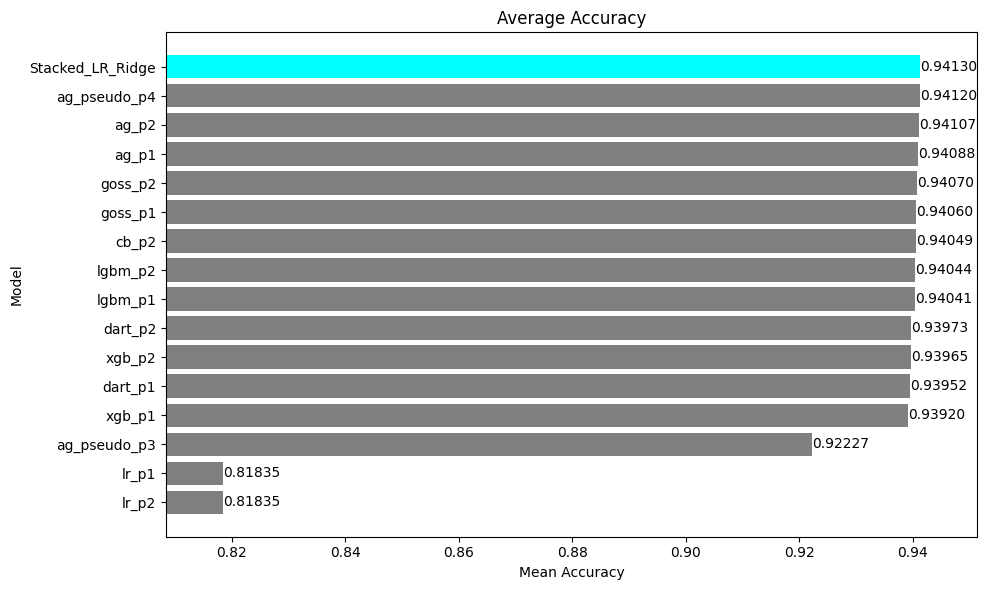

In [18]:
df_scores = pd.DataFrame({
    "model": list(all_scores.keys()),
    "mean_accuracy": [np.mean(scores) for scores in all_scores.values()]
}).sort_values("mean_accuracy", ascending=False).reset_index(drop=True)

print(df_scores)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_scores, x="mean_accuracy", y="model", color="grey")

# Tô màu stacked model khác, ví dụ "Stacked_LR_Ridge"
for i, row in df_scores.iterrows():
    if row["model"] == "Stacked_LR_Ridge":
        plt.barh(i, row["mean_accuracy"], color="cyan")

# Thêm giá trị mean_accuracy lên thanh bar
for i, row in df_scores.iterrows():
    plt.text(row["mean_accuracy"], i, f"{row['mean_accuracy']:.5f}", va="center", ha="left")

plt.title("Average Accuracy")
plt.xlabel("Mean Accuracy")
plt.ylabel("Model")
plt.xlim(df_scores["mean_accuracy"].min() - 0.01,
         df_scores["mean_accuracy"].max() + 0.01)

plt.tight_layout()
plt.show()
